In [1]:
import os
import cv2
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
import matplotlib.pyplot as plt

In [2]:
import os
from zipfile import ZipFile


!pip install kaggle


os.environ['KAGGLE_USERNAME'] = "cruk12"
os.environ['KAGGLE_KEY'] = "f6ac77148464b981fcc85de69da4347e"


!kaggle datasets download -d jessicali9530/lfw-dataset


with ZipFile('lfw-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('lfw-dataset')


os.remove('lfw-dataset.zip')


 93% 105M/112M [00:00<00:00, 128MB/s] 
100% 112M/112M [00:00<00:00, 124MB/s]


In [3]:

def extract_features(image_path, model):
    image = Image.open(image_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = preprocess(image)
    image = image.unsqueeze(0)
    with torch.no_grad():
        features = model(image)
    features = features.squeeze(0)
    return features


def compute_hog(img):
    resized_img = resize(img, (128*4, 64*4))
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)
    return fd


def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))
    val_ar.append(get_pixel(img, center, x, y+1))
    val_ar.append(get_pixel(img, center, x+1, y+1))
    val_ar.append(get_pixel(img, center, x+1, y))
    val_ar.append(get_pixel(img, center, x+1, y-1))
    val_ar.append(get_pixel(img, center, x, y-1))
    val_ar.append(get_pixel(img, center, x-1, y-1))
    val_ar.append(get_pixel(img, center, x-1, y))

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return hist_lbp.flatten()


In [4]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 67.3MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


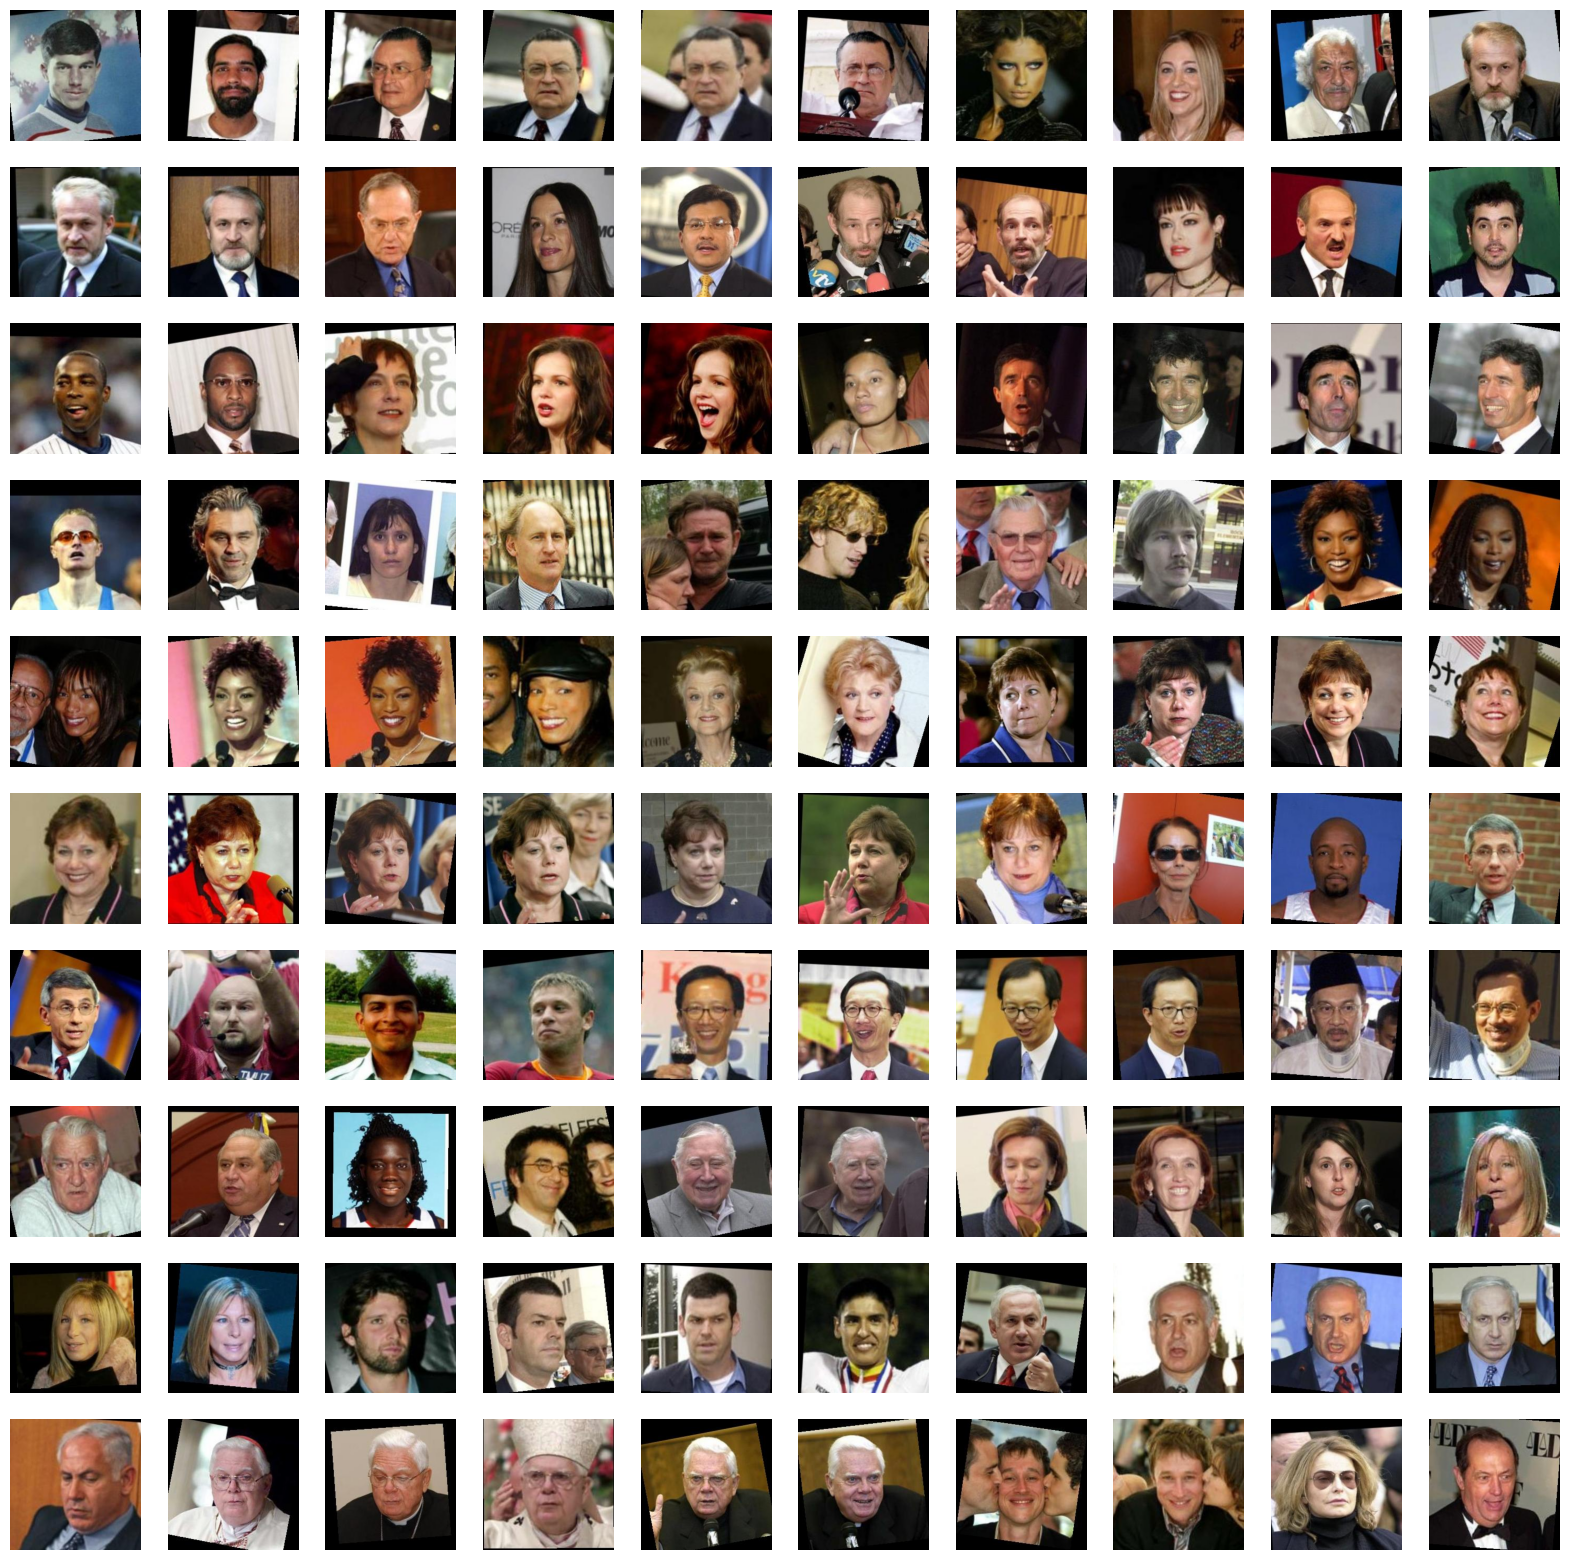

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Step 1: Read the CSV file
people_df = pd.read_csv('/content/lfw-dataset/people.csv')

# Step 2: Extract file paths
lfw_folder_path = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
image_paths = []
for index, row in people_df.iterrows():
    person_name = str(row['name']).replace(' ', '_')  # Convert to string and replace spaces with underscores
    num_images = row['images']
    if pd.notnull(num_images):  # Check if num_images is not NaN
        num_images = int(num_images)  # Convert to integer
        for i in range(1, num_images + 1):
            image_paths.append(os.path.join(lfw_folder_path, person_name, f'{person_name}_{i:04d}.jpg'))  # Adjust image name format

# Step 3: Display the first 100 images
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    image_path = image_paths[i]
    image = Image.open(image_path)
    ax.imshow(image)
    ax.axis('off')

plt.show()

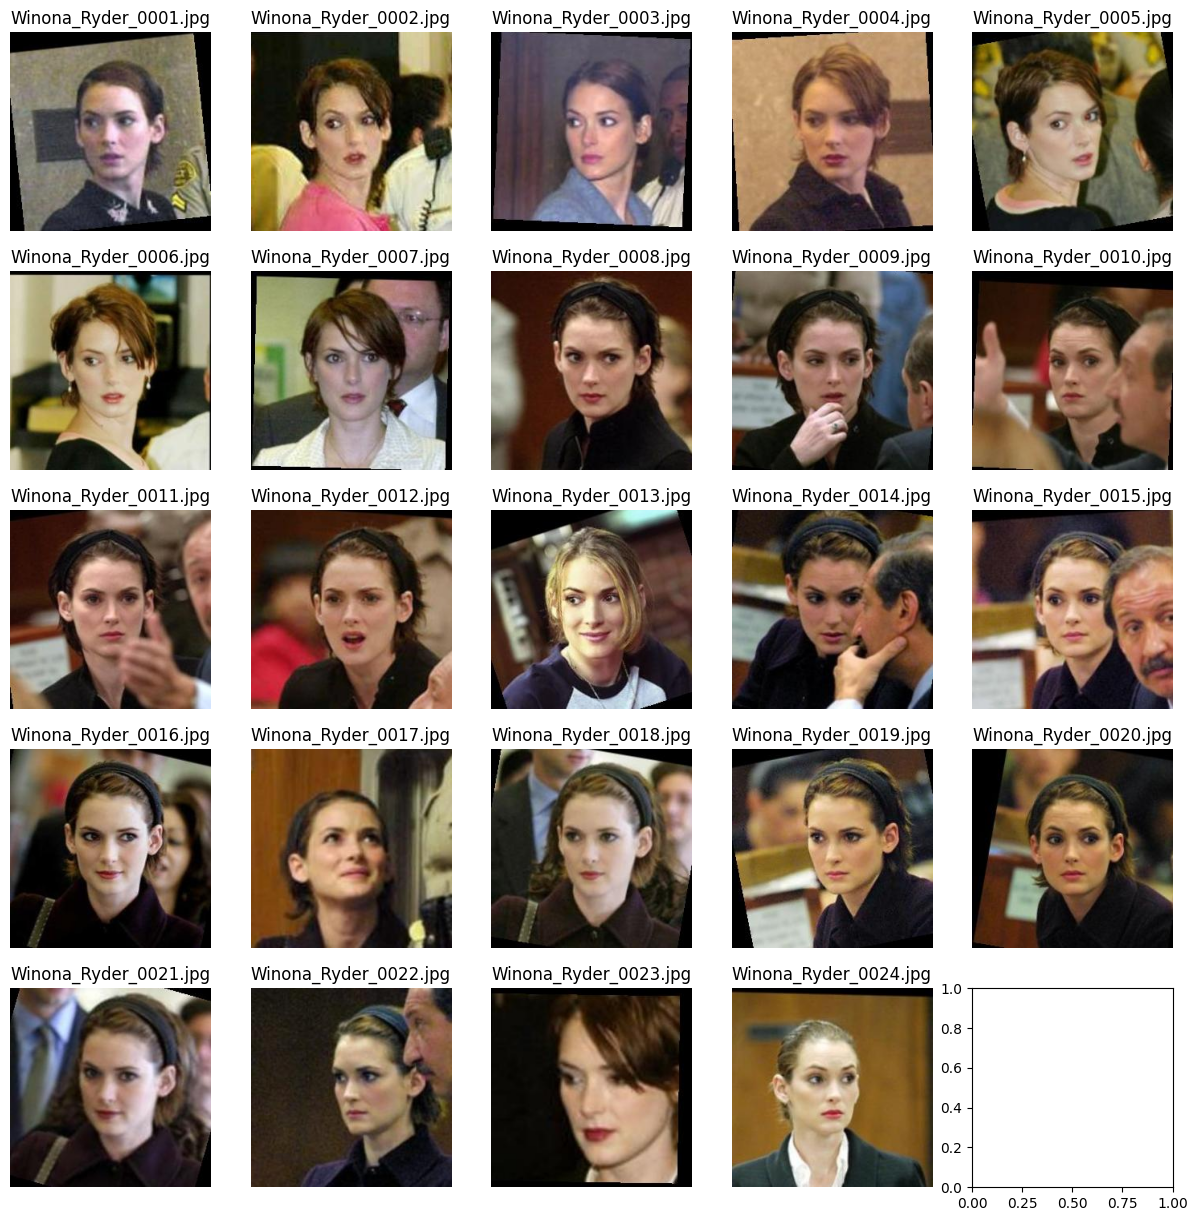

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Step 1: Read the CSV file
people_df = pd.read_csv('/content/lfw-dataset/people.csv')

# Step 2: Extract file paths
lfw_folder_path = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'  # Path to the images folder
image_paths = {}
for index, row in people_df.iterrows():
    person_name = str(row['name']).replace(' ', '_')  # Convert to string and replace spaces with underscores
    num_images = row['images']
    if pd.notnull(num_images):  # Check if num_images is not NaN
        num_images = int(num_images)  # Convert to integer
        image_paths[person_name] = []
        for i in range(1, num_images + 1):
            image_paths[person_name].append(f'{person_name}_{i:04d}.jpg')  # Format the image number with leading zeros

# Step 3: Input the person's name
person_name_input = "Winona_Ryder"

# Step 4: Display all images of the input person in a single plot
if person_name_input in image_paths:
    person_images = image_paths[person_name_input]

    # Calculate grid size
    num_images = len(person_images)
    num_cols = 5  # Number of columns
    num_rows = (num_images + num_cols - 1) // num_cols  # Number of rows

    # Create subplots with larger figure size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flat):
        if i < num_images:
            image_name = person_images[i]
            image_path = os.path.join(lfw_folder_path, person_name_input, image_name)
            image = imread(image_path)

            ax.imshow(image)
            ax.set_title(image_name)
            ax.axis('off')  # Remove grid and axes scales
            ax.set_aspect('auto')  # Disable aspect ratio

    # plt.tight_layout()
    plt.show()
else:
    print("Person not found in the dataset.")



In [5]:
lfw_folder = '/content/lfw-dataset/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                # cnn_feature = extract_features(image_path, resnet).numpy()
                hog_feature = hog_feature.reshape(-1)
                lbp_feature = lbp_feature.reshape(-1)
                # cnn_feature = cnn_feature.flatten()
                combined_feature = np.concatenate((hog_feature, lbp_feature))

                X.append(combined_feature)
                y.append(folder_name)


<ipython-input-3-8d0f7df1f55f>:19: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),


In [6]:
np.array(X).shape

(1288, 70564)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [8]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

KNN - sklearn

In [9]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_encoded)
y_pred_knn = knn_clf.predict(X_test)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)
print("KNN Classifier")
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))


KNN Classifier
Accuracy: 0.3953488372093023
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.40      0.29      0.33        14
     Colin_Powell       0.29      0.45      0.35        40
  Donald_Rumsfeld       0.36      0.24      0.29        34
    George_W_Bush       0.47      0.62      0.54       109
Gerhard_Schroeder       0.11      0.04      0.06        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.33      0.11      0.17        27

         accuracy                           0.40       258
        macro avg       0.28      0.25      0.25       258
     weighted avg       0.36      0.40      0.36       258



Training Accuracy using some hyperparameters

In [10]:
# printing training accuracy
# best_params = grid_results.best_params_
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'manhattan', n_neighbors= 5, weights= 'distance')
best_knn_clf.fit(X_train, y_train_encoded)

y_train_pred = best_knn_clf.predict(X_train)
training_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 1.0


Test Accuracy

In [11]:

# best_params = grid_results.best_params_

# knn with best hyperparameters
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'manhattan', n_neighbors= 5, weights= 'distance')

# train
best_knn_clf.fit(X_train, y_train_encoded)

# prediction
y_pred = best_knn_clf.predict(X_test)

# accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))


Accuracy: 0.43410852713178294
Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.21      0.29        14
           1       0.35      0.45      0.39        40
           2       0.67      0.24      0.35        34
           3       0.51      0.68      0.58       109
           4       0.15      0.09      0.11        23
           5       0.00      0.00      0.00        11
           6       0.30      0.26      0.28        27

    accuracy                           0.43       258
   macro avg       0.34      0.27      0.29       258
weighted avg       0.42      0.43      0.41       258



PCA + KNN

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_pca, y_train_encoded)
y_pred_knn = knn_clf.predict(X_test_pca)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)

print("KNN Classifier")
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classifier
Accuracy: 0.3798449612403101
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.13      0.14      0.14        14
     Colin_Powell       0.26      0.38      0.31        40
  Donald_Rumsfeld       0.32      0.21      0.25        34
    George_W_Bush       0.50      0.64      0.56       109
Gerhard_Schroeder       0.14      0.09      0.11        23
      Hugo_Chavez       0.00      0.00      0.00        11
       Tony_Blair       0.20      0.07      0.11        27

         accuracy                           0.38       258
        macro avg       0.22      0.22      0.21       258
     weighted avg       0.33      0.38      0.35       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


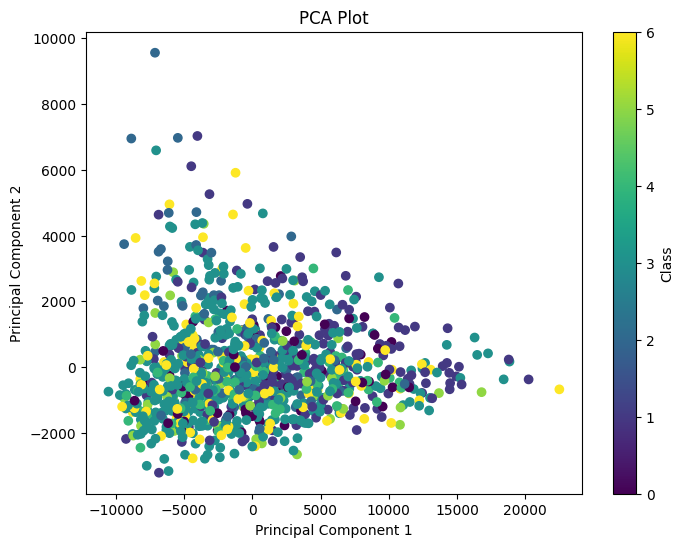

In [13]:
# Plot PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train_encoded, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Plot')
plt.colorbar(label='Class')
plt.show()

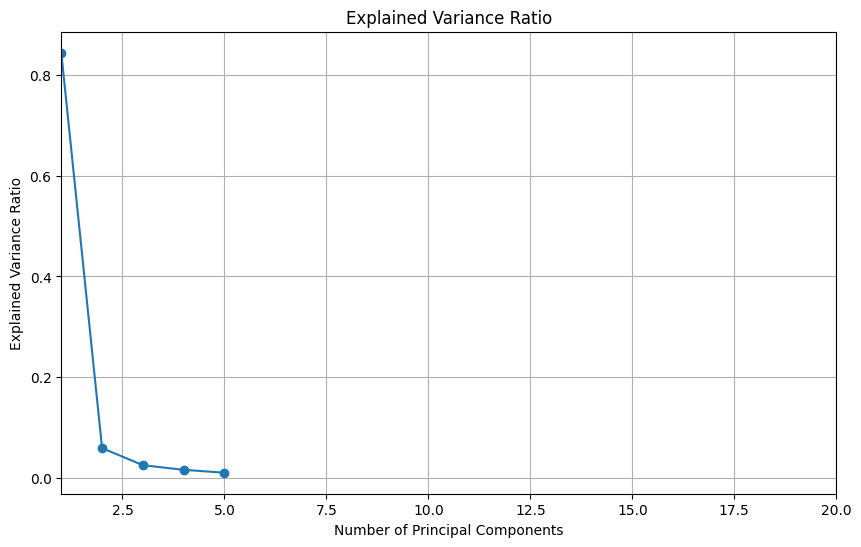

In [14]:
import matplotlib.pyplot as plt

# Extract explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.xlim(1, 20)  # Limiting to first 20 components
plt.grid(True)
plt.show()


Training Accuracy to check overfitting

In [15]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_pca, y_train_encoded)
y_pred_knn = knn_clf.predict(X_train_pca)
accuracy_knn = accuracy_score(y_train_encoded, y_pred_knn)

print("KNN Classifier")
print("Training Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classifier
Training Accuracy: 0.5320388349514563
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.28      0.27      0.28        63
     Colin_Powell       0.51      0.58      0.54       196
  Donald_Rumsfeld       0.48      0.39      0.43        87
    George_W_Bush       0.59      0.81      0.68       421
Gerhard_Schroeder       0.40      0.19      0.25        86
      Hugo_Chavez       0.30      0.05      0.09        60
       Tony_Blair       0.51      0.21      0.29       117

         accuracy                           0.53      1030
        macro avg       0.44      0.36      0.37      1030
     weighted avg       0.50      0.53      0.49      1030



Using some hyperparameters

In [16]:
# printing training accuracy
# best_params = grid_results.best_params_
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'euclidean', n_neighbors= 9, weights= 'distance')
best_knn_clf.fit(X_train_pca, y_train_encoded)
y_train_pred = best_knn_clf.predict(X_train_pca)
training_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 1.0


Testing Accuracy

In [17]:

# best_params = grid_results.best_params_

# knn with best hyperparameters
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'euclidean', n_neighbors= 9, weights= 'distance')

# train
best_knn_clf.fit(X_train_pca, y_train_encoded)

# prediction
y_pred = best_knn_clf.predict(X_test_pca)

# accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Accuracy: 0.4069767441860465
Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.07      0.11        14
           1       0.30      0.25      0.27        40
           2       0.27      0.09      0.13        34
           3       0.49      0.80      0.60       109
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        11
           6       0.22      0.15      0.18        27

    accuracy                           0.41       258
   macro avg       0.22      0.19      0.19       258
weighted avg       0.33      0.41      0.34       258



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


LDA + KNN

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_lda, y_train_encoded)
y_pred_knn = knn_clf.predict(X_test_lda)
accuracy_knn = accuracy_score(y_test_encoded, y_pred_knn)

print("KNN Classifier")
print("Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classifier
Accuracy: 0.8178294573643411
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.79      0.79      0.79        14
     Colin_Powell       0.92      0.90      0.91        40
  Donald_Rumsfeld       0.96      0.74      0.83        34
    George_W_Bush       0.75      0.97      0.85       109
Gerhard_Schroeder       0.85      0.48      0.61        23
      Hugo_Chavez       0.60      0.27      0.37        11
       Tony_Blair       0.95      0.70      0.81        27

         accuracy                           0.82       258
        macro avg       0.83      0.69      0.74       258
     weighted avg       0.83      0.82      0.81       258



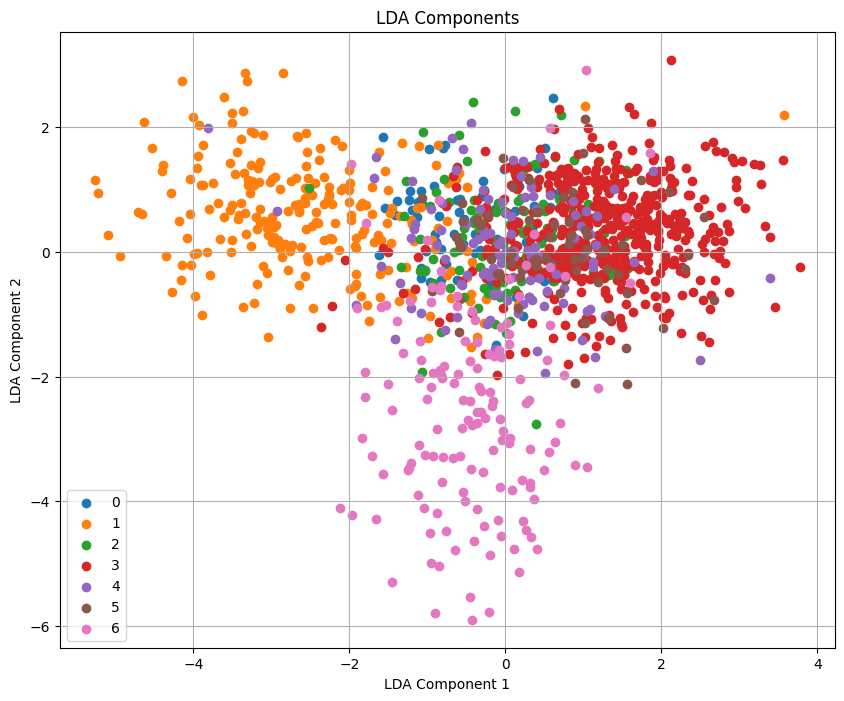

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Concatenate the training and testing data for visualization
X_combined_lda = np.vstack((X_train_lda, X_test_lda))
y_combined = np.hstack((y_train_encoded, y_test_encoded))

# Plotting a scatter plot
plt.figure(figsize=(10, 8))

# Plotting each class separately
for label in np.unique(y_combined):
    plt.scatter(X_combined_lda[y_combined == label, 0],
                X_combined_lda[y_combined == label, 1],
                label=label)

plt.xlabel('LDA Component 1')
plt.ylabel('LDA Component 2')
plt.title('LDA Components')
plt.legend()
plt.grid(True)
plt.show()


Training Accuracy

In [20]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_lda, y_train_encoded)
y_pred_knn = knn_clf.predict(X_train_lda)
accuracy_knn = accuracy_score(y_train_encoded, y_pred_knn)

print("KNN Classifier")
print("Training Accuracy:", accuracy_knn)
print("Classification Report:")
print(classification_report(y_train_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classifier
Training Accuracy: 0.8611650485436894
Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.81      0.81      0.81        63
     Colin_Powell       0.85      0.90      0.88       196
  Donald_Rumsfeld       0.85      0.77      0.81        87
    George_W_Bush       0.87      0.95      0.90       421
Gerhard_Schroeder       0.81      0.69      0.74        86
      Hugo_Chavez       0.92      0.75      0.83        60
       Tony_Blair       0.91      0.77      0.83       117

         accuracy                           0.86      1030
        macro avg       0.86      0.80      0.83      1030
     weighted avg       0.86      0.86      0.86      1030



Using some hyperparameters

In [21]:
# printing training accuracy
# best_params = grid_results.best_params_
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'euclidean', n_neighbors= 13, weights= 'uniform')
best_knn_clf.fit(X_train_lda,y_train_encoded)
y_train_pred = best_knn_clf.predict(X_train_lda)
training_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Training Accuracy:", training_accuracy)

Training Accuracy: 0.8427184466019417


Testing Accuracy

In [22]:

# best_params = grid_results.best_params_

# knn with best hyperparameters
best_knn_clf = KNeighborsClassifier(leaf_size= 1, metric= 'euclidean', n_neighbors= 13, weights= 'uniform')

# train
best_knn_clf.fit(X_train_lda, y_train_encoded)

# prediction
y_pred = best_knn_clf.predict(X_test_lda)

# accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred))

Accuracy: 0.8178294573643411
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.64      0.78        14
           1       0.97      0.95      0.96        40
           2       1.00      0.71      0.83        34
           3       0.71      1.00      0.83       109
           4       1.00      0.43      0.61        23
           5       1.00      0.09      0.17        11
           6       0.95      0.74      0.83        27

    accuracy                           0.82       258
   macro avg       0.95      0.65      0.72       258
weighted avg       0.87      0.82      0.80       258



Confusion Matrix:
[[  9   0   0   4   0   0   1]
 [  0  38   0   2   0   0   0]
 [  0   0  24  10   0   0   0]
 [  0   0   0 109   0   0   0]
 [  0   0   0  13  10   0   0]
 [  0   0   0  10   0   1   0]
 [  0   1   0   6   0   0  20]]


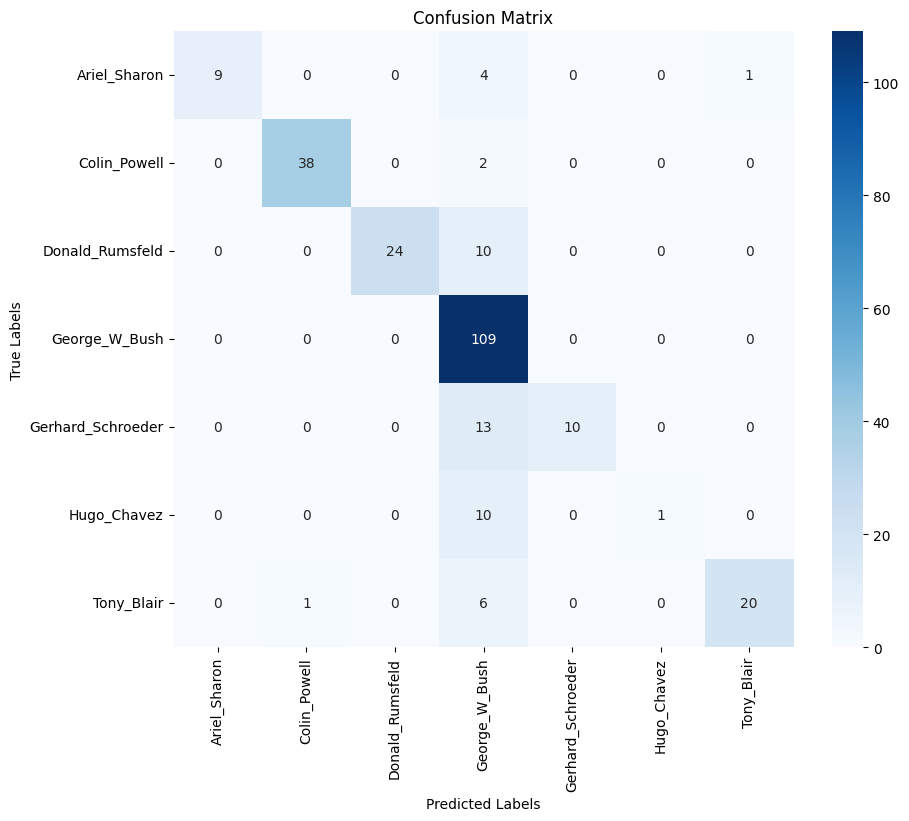

In [23]:
# Train the KNN classifier using the best parameters
knn_classifier = KNeighborsClassifier(leaf_size= 1, metric= 'euclidean', n_neighbors= 13, weights= 'uniform')
knn_classifier.fit(X_train_lda, y_train_encoded)

# Make predictions on the testing set
y_pred = knn_classifier.predict(X_test_lda)

# Get the unique labels in the dataset
unique_labels = np.unique(y)

# Create an empty dictionary to map label indices to their corresponding names
label_map = {}

# Iterate over the unique labels and add them to the label_map
for i, label in enumerate(unique_labels):
    label_map[i] = label

# Map the numeric labels to their corresponding names
y_test_labels = [label_map[label] for label in y_test_encoded]
y_pred_labels = [label_map[label] for label in y_pred]

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels, labels=unique_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Optionally, you can visualize the confusion matrix for better understanding
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()